In [4]:
import os
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torch.optim import AdamW



In [5]:
base_dir = os.getcwd()
train_path = os.path.join(base_dir, "../data/train_data.csv")
test_path = os.path.join(base_dir, "../data/test_data_clean.csv")

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)




In [6]:
train_df["label"] = (train_df["label"] > 0.4).astype(int)
test_df["isHate"] = (test_df["isHate"] > 0.4).astype(int)

train_texts = train_df["text"].astype(str).tolist()
train_labels = train_df["label"].tolist()
test_texts = test_df["comment"].astype(str).tolist()
test_labels = test_df["isHate"].tolist()


In [7]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize(texts):
    return tokenizer(texts, truncation=True, padding='max_length', max_length=64, return_tensors="pt")

class TextDataset(Dataset):
    def __init__(self, texts, labels):
        encodings = tokenize(texts)
        self.input_ids = encodings['input_ids']
        self.attn_mask = encodings['attention_mask']
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attn_mask[idx],
            'label': self.labels[idx]
        }


In [8]:
train_dataset = TextDataset(train_texts, train_labels)
test_dataset = TextDataset(test_texts, test_labels)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)



In [9]:
class DistilBertClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.classifier = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 1),
            nn.Sigmoid()
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.last_hidden_state[:, 0]  # [CLS] token
        return self.classifier(pooled).squeeze()

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = DistilBertClassifier().to(device)
criterion = nn.BCELoss()
optimizer = AdamW(model.parameters(), lr=2e-5)



In [10]:
for epoch in range(3):
    model.train()
    total_loss = 0

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attn_mask = batch['attention_mask'].to(device)
        labels = batch['label'].float().to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attn_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch + 1} Loss: {total_loss / len(train_loader):.4f}")



Epoch 1 Loss: 0.4730
Epoch 2 Loss: 0.3345
Epoch 3 Loss: 0.2443


Accuracy: 0.7855711422845691
F1 Score: 0.7421686746987952
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.84      0.82       565
           1       0.78      0.71      0.74       433

    accuracy                           0.79       998
   macro avg       0.78      0.78      0.78       998
weighted avg       0.78      0.79      0.78       998



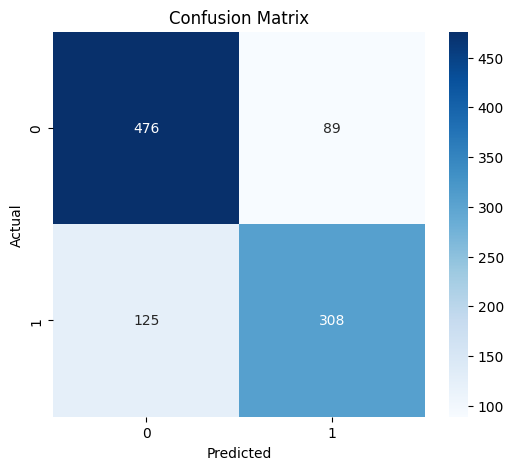

In [11]:
model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attn_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        probs = model(input_ids, attn_mask)
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

probs = np.array(all_probs)
custom_preds = (probs > 0.4).astype(int)
y_true = np.array(all_labels)

print("Accuracy:", accuracy_score(y_true, custom_preds))
print("F1 Score:", f1_score(y_true, custom_preds))
print("Classification Report:\n", classification_report(y_true, custom_preds))

cm = confusion_matrix(y_true, custom_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


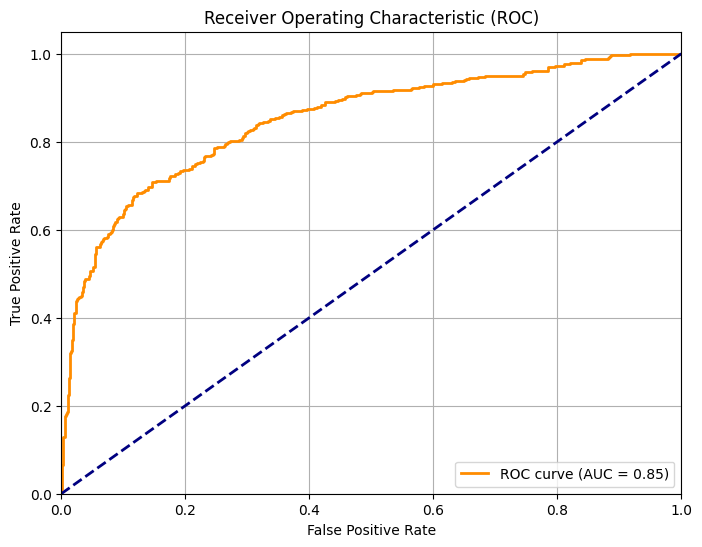

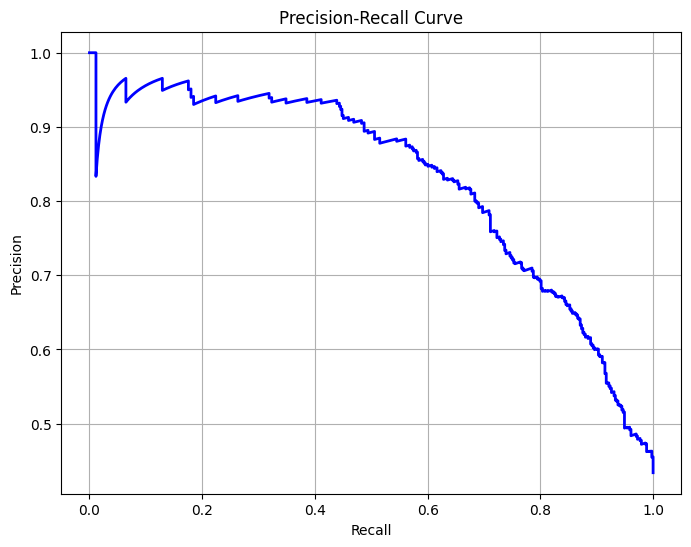

In [12]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

fpr, tpr, _ = roc_curve(y_true, probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid()
plt.show()

precision, recall, _ = precision_recall_curve(y_true, probs)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid()
plt.show()



In [ ]:
import os
import torch
from transformers import BertConfig

save_directory = "saved_bert_model"
os.makedirs(save_directory, exist_ok=True)

torch.save(model.state_dict(), os.path.join(save_directory, "pytorch_model.bin"))

tokenizer.save_pretrained(save_directory)

config = BertConfig.from_pretrained("bert-base-uncased")
config.save_pretrained(save_directory)

print(f" Model and tokenizer saved to '{save_directory}'")





✅ Model and tokenizer saved to 'saved_bert_model'
